# Прогнозирование температуры звезды

Задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
Закон смещения Вина.
Закон Стефана-Больцмана.
Спектральный анализ.
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики:

Относительная светимость L/Lo — светимость звезды относительно Солнца.

Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.

Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.

Тип звезды.
Тип звезды	Номер, соответствующий типу:

 - Коричневый карлик	0
 
 - Красный карлик	1
 
 - Белый карлик	2
 
 - Звёзды главной последовательности	3
 
 - Сверхгигант	4
 
 - Гипергигант	5
 
Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

### Импортируем библиотеки

In [1]:
%pip install torch
%pip install optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U scikit-learn

In [3]:
import pandas as pd
import numpy as np
from math import ceil
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  OneHotEncoder

import torch
import torch.nn as nn
import optuna

import warnings
warnings.filterwarnings("ignore")

c:\Users\shawn\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Функции

In [4]:
# Функция для получения общей информации о датафрейме
def get_info(data):
    display(data.sample(10))
    display(data.info())
    display(data.describe(include='all'))
    print('Количество явных дубликатов:', data.duplicated().sum())
    display(data.isna().sum())
    numeric_data = data.select_dtypes(include=['number'])
    display(numeric_data.corr())
    plt.rcParams['figure.figsize'] = (9, 7)
    sns.heatmap(numeric_data.corr(), annot=True, linewidths=3, linecolor='white')
    data.hist(figsize=(9, 9));

In [5]:

try:
    df = pd.read_csv('/datasets/6_class.csv')
except:
    df = pd.read_csv('./6_class.csv')



,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
107,107,12893,184000.000000,36.000,-6.340,4,Blue
186,186,2968,0.000461,0.119,17.450,0,Red
72,72,3304,0.008500,0.180,13.200,1,Red
5,5,2840,0.000650,0.110,16.980,0,Red
41,41,3365,340000.000000,23.000,-6.200,4,Red
193,193,3212,0.001600,0.378,12.854,1,Red
74,74,3550,0.004000,0.291,10.890,1,Red
52,52,3834,272000.000000,1183.000,-9.200,5,Red
44,44,3008,280000.000000,25.000,-6.000,4,Red
124,124,3511,0.000640,0.109,17.120,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


None

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240
unique,NaN,NaN,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,NaN,NaN,Red
freq,NaN,NaN,NaN,NaN,NaN,NaN,112
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000,NaN
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394,NaN
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000,NaN
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000,NaN
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000,NaN
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000,NaN


Количество явных дубликатов: 0


Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
Unnamed: 0,1.000000,0.391056,0.322719,0.167608,-0.257015,0.246505
Temperature (K),0.391056,1.000000,0.393404,0.064216,-0.420261,0.411129
Luminosity(L/Lo),0.322719,0.393404,1.000000,0.526516,-0.692619,0.676845
Radius(R/Ro),0.167608,0.064216,0.526516,1.000000,-0.608728,0.660975
Absolute magnitude(Mv),-0.257015,-0.420261,-0.692619,-0.608728,1.000000,-0.955276
Star type,0.246505,0.411129,0.676845,0.660975,-0.955276,1.000000


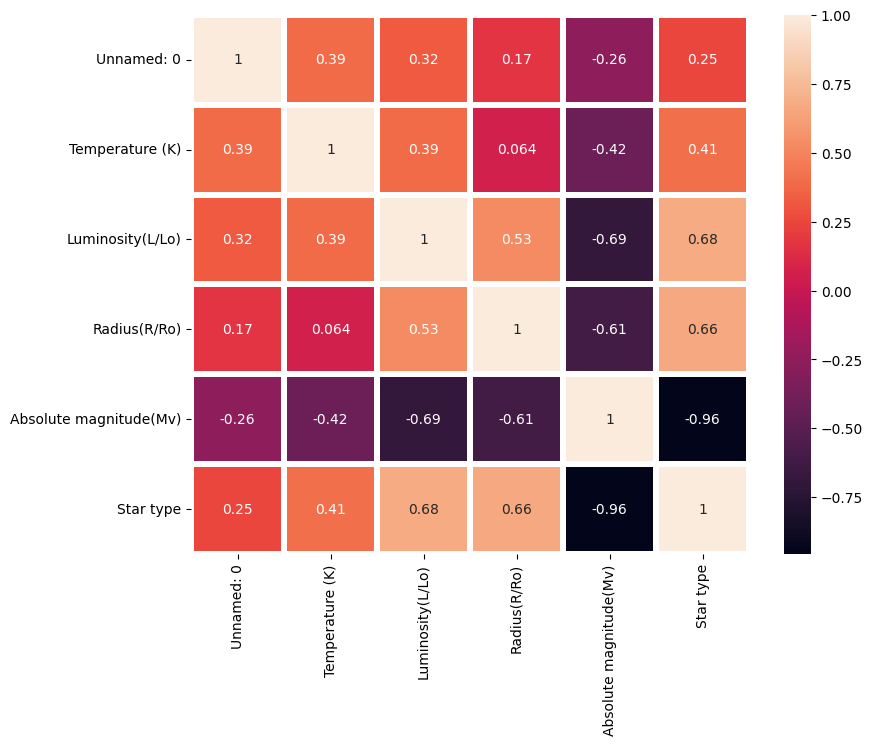

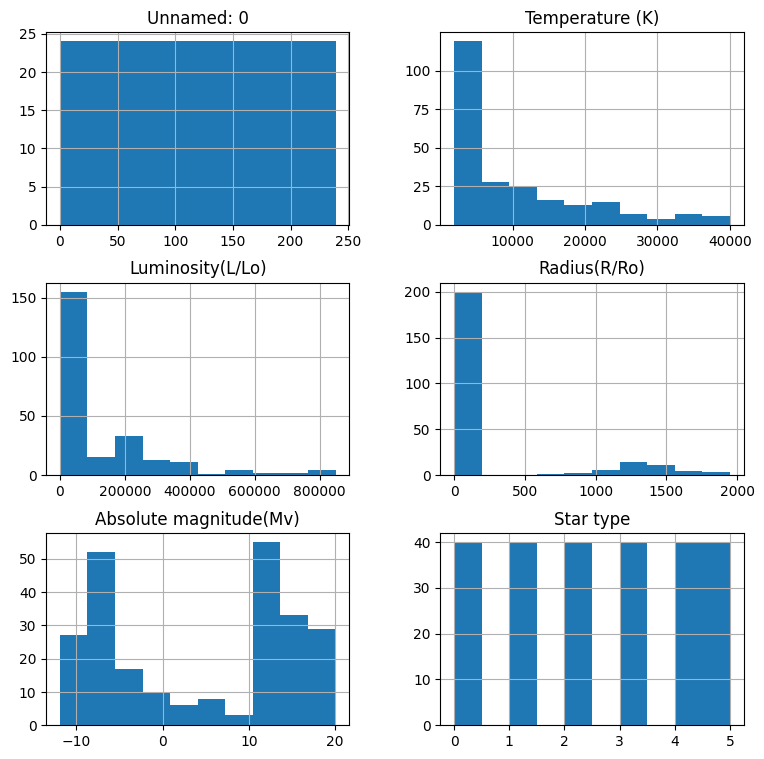

In [6]:
get_info(df)

**Выводы:** Явных дубликатов и пропусков в данных нет. Нужно преобразовать типы данных в столбцах star_type и star_color. Видим, что  столбц Unnamed: 0 дублирует индекс. Из матрицы корреляции видно, что есть два мультиколлениарных признака Star type и Absolute magnitude. В столбцах Temperature(K), Luminosity(L/Lo), Radius(R/Ro) - наблюдаются выбросы. Рассмотрим их далее более детально. Нужно изменить названия столбцов.

## Предобработка и анализ данных

Измения названия столбцов

In [7]:
df.rename(columns = {'Unnamed: 0' : 'unnamed_0', 'Temperature (K)': 'temperature', 'Luminosity(L/Lo)': 'luminosity', 'Radius(R/Ro)': 'radius',
                      'Absolute magnitude(Mv)': 'absolute_magnitude', 'Star type': 'star_type', 'Star color': 'star_color'}, inplace = True )
df.columns

Index(['unnamed_0', 'temperature', 'luminosity', 'radius',
       'absolute_magnitude', 'star_type', 'star_color'],
      dtype='object')

Переведем признаки star_type и star_color к категориальному типу.

In [8]:
df['star_type'] = df['star_type'].astype('category')
df['star_color'] = df['star_color'].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   unnamed_0           240 non-null    int64   
 1   temperature         240 non-null    int64   
 2   luminosity          240 non-null    float64 
 3   radius              240 non-null    float64 
 4   absolute_magnitude  240 non-null    float64 
 5   star_type           240 non-null    category
 6   star_color          240 non-null    category
dtypes: category(2), float64(3), int64(2)
memory usage: 10.9 KB


### Рассмотрим каждый столбец отдельно

Удалим столбец unnamed_0.

In [10]:
df.drop('unnamed_0', axis=1, inplace=True)

In [11]:
df.head()

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


#### Столбец температуры

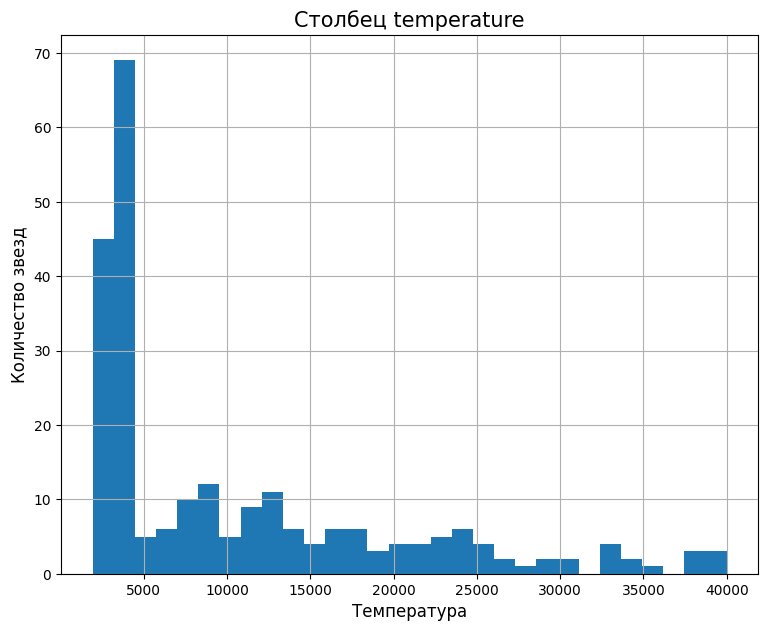

In [12]:
plt.xlabel("Температура", fontsize = 12)
plt.ylabel("Количество звезд", fontsize = 12)
plt.title("Столбец temperature", fontsize = 15)
df['temperature'].hist(bins= 30)
plt.show()

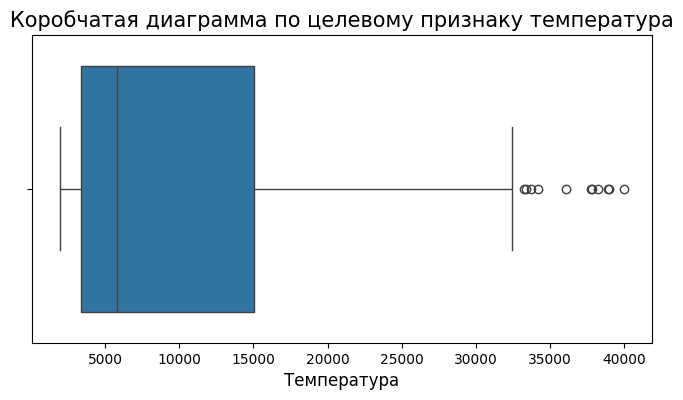

In [13]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df['temperature'], orient='h')
plt.xlabel('Температура', fontsize=12)
plt.title('Коробчатая диаграмма по целевому признаку температура', fontsize = 15)
plt.show()

In [14]:
df.query('temperature > 33000')

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
30,39000,204000.0,10.60,-4.70,3,Blue
49,33750,220000.0,26.00,-6.10,4,Blue
99,36108,198000.0,10.20,-4.40,3,Blue
100,33300,240000.0,12.00,-6.50,4,Blue
101,40000,813000.0,14.00,-6.23,4,Blue
109,33421,352000.0,67.00,-5.79,4,Blue
159,37800,202900.0,6.86,-4.56,3,Blue
214,34190,198200.0,6.39,-4.57,3,Blue
231,38234,272830.0,1356.00,-9.29,5,Blue
235,38940,374830.0,1356.00,-9.93,5,Blue


Ошибки в данных нет, голубые звезды действительно могут достигать таких высоких температур.

In [15]:
df.query('temperature < 5000')

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.120,0,Red
1,3042,0.000500,0.1542,16.600,0,Red
2,2600,0.000300,0.1020,18.700,0,Red
3,2800,0.000200,0.1600,16.650,0,Red
4,1939,0.000138,0.1030,20.060,0,Red
...,...,...,...,...,...,...
195,3598,0.002700,0.6700,13.667,1,Red
196,3142,0.001320,0.2580,14.120,1,Red
197,3496,0.001250,0.3360,14.940,1,Red
198,3324,0.006500,0.4710,12.780,1,Red


In [16]:
df['star_color'].value_counts()

star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
yellowish               2
Orange                  2
Blue                    1
White-Yellow            1
Orange-Red              1
Yellowish               1
Blue-White              1
Blue white              1
Pale yellow orange      1
Name: count, dtype: int64

В данных преобдатают звезду красного цвета с температурой до 6000 K.

### Столбец относительной светимости

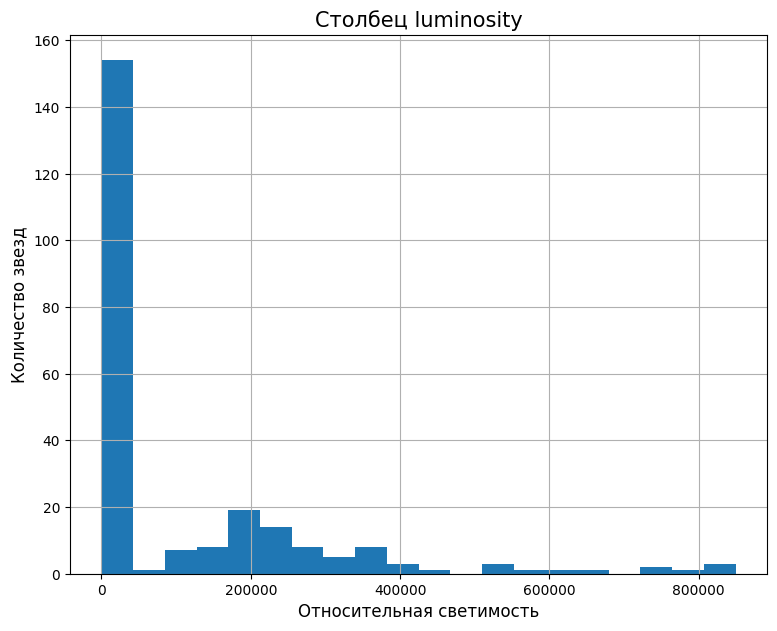

In [17]:
plt.xlabel("Относительная светимость", fontsize = 12)
plt.ylabel("Количество звезд", fontsize = 12)
plt.title("Столбец luminosity", fontsize = 15)
df['luminosity'].hist(bins= 20)
plt.show()

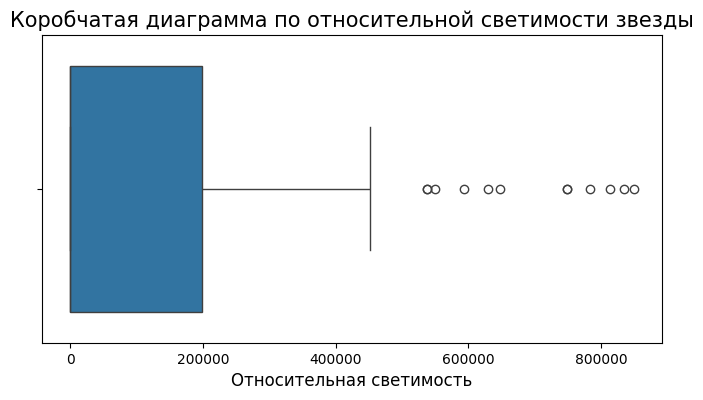

In [18]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df['luminosity'], orient='h')
plt.xlabel('Относительная светимость', fontsize=12)
plt.title('Коробчатая диаграмма по относительной светимости звезды', fontsize = 15)
plt.show()

In [19]:
df.query('luminosity > 430000')

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,Orange
101,40000,813000.0,14.0,-6.230,4,Blue
162,12675,452000.0,83.0,-5.620,4,Blue
172,4287,630000.0,1315.0,-9.200,5,Orange
223,23440,537430.0,81.0,-5.975,4,Blue
226,9892,593900.0,80.0,-7.262,4,Blue
227,10930,783930.0,25.0,-6.224,4,Blue
229,21738,748890.0,92.0,-7.346,4,Blue
232,32489,648430.0,1948.5,-10.840,5,Blue
233,27739,849420.0,1252.0,-7.590,5,Blue-white


Здесь также выбросы не являются ошибкой, поскольку есть звезды с такими показателями светимости, что опять же характерно для звезд с отрицательной абсолютной величиной. Пример ярчайшая звезда созвездия Кормы, звезда имеет собственное имя Наос и ее светимость достигает 870 000 L.

### Столбец относительного радиуса 

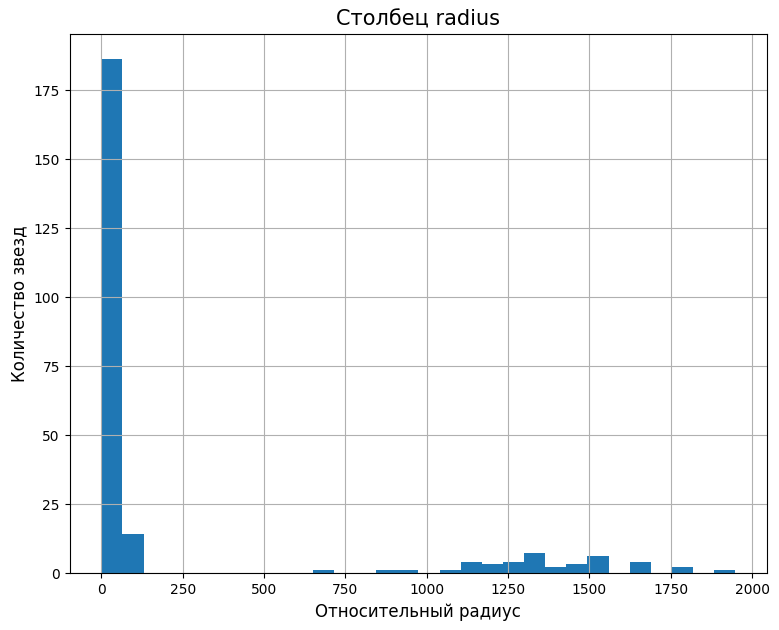

In [20]:
plt.xlabel("Относительный радиус", fontsize=12)
plt.ylabel("Количество звезд", fontsize=12)
plt.title("Столбец radius", fontsize=15)
df['radius'].hist(bins=30)
plt.show()

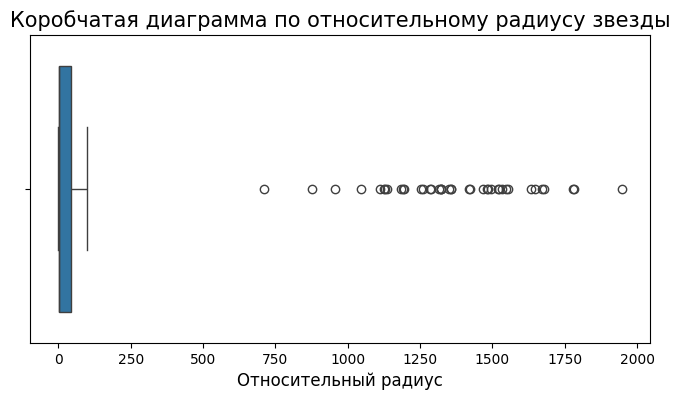

In [21]:
plt.figure(figsize = (8, 4))
sns.boxplot(data = df['radius'], orient='h')
plt.xlabel('Относительный радиус', fontsize=12)
plt.title('Коробчатая диаграмма по относительному радиусу звезды', fontsize = 15)
plt.show()

In [22]:
df.query('radius > 600')

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,Red
51,3750,283000.0,1260.0,-7.63,5,Red
52,3834,272000.0,1183.0,-9.20,5,Red
53,3749,550000.0,1648.0,-8.05,5,Orange
54,3650,310000.0,1324.0,-7.79,5,Red
55,3450,263000.0,1349.0,-11.75,5,Red
56,3660,363000.0,1673.0,-11.92,5,Red
57,3450,174000.0,1284.0,-11.28,5,Red
58,3752,209000.0,955.0,-11.24,5,Red
59,3535,195000.0,1546.0,-11.36,5,Red


Схожая картина с прерыдущими столбцами. Такие характеристики звезд имеют место быть. Ничего менять не будем.

#### Столбец абсолютной звёздной величины 

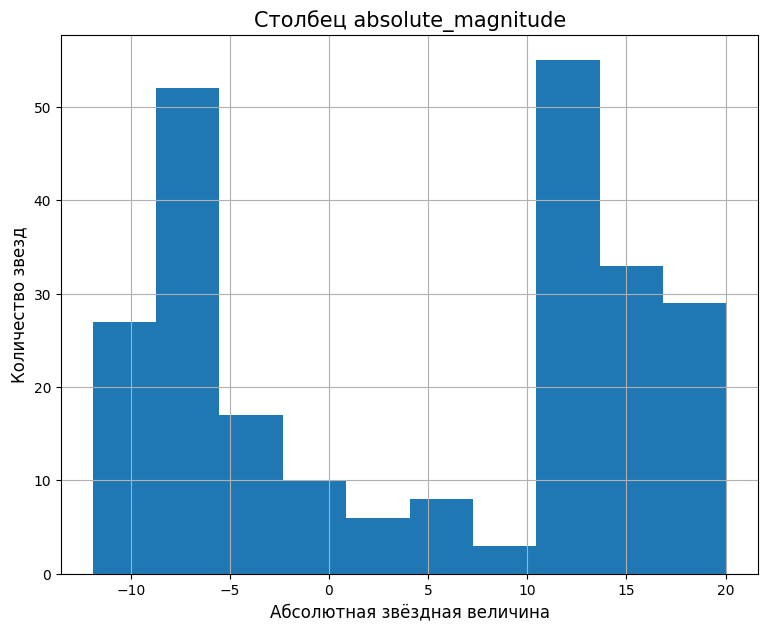

In [23]:
plt.xlabel("Абсолютная звёздная величина", fontsize=12)
plt.ylabel("Количество звезд", fontsize=12)
plt.title("Столбец absolute_magnitude", fontsize=15)
df['absolute_magnitude'].hist(bins=10)
plt.show()

График имеет симметричное увеличение в обе стороны, что говорит о нисзком количестве схожиж звезд, по данному показателю, среди изученных.

#### Столбец типов звезд

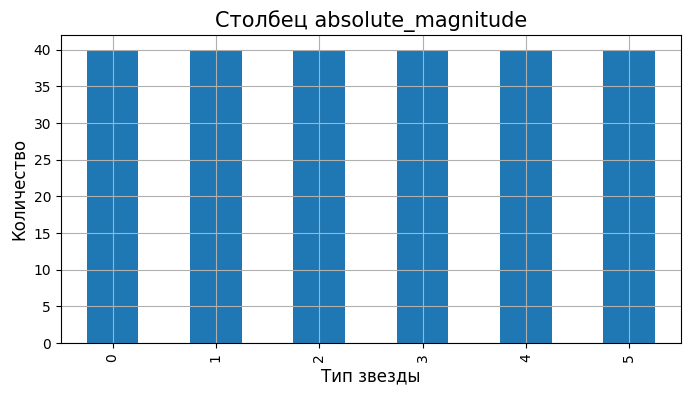

In [24]:
df['star_type'].value_counts().plot.bar(figsize=(8, 4), grid=True)
plt.title('Столбец absolute_magnitude', fontsize=15)
plt.xlabel('Тип звезды', fontsize=12)
plt.ylabel('Количество', fontsize=12);

Нам даны 6 типов звезд, по 40 звезд каждого типа.

#### Стобце цвета звезд

In [25]:
df['star_color'].unique()

['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white', ..., 'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ', 'Blue-White']
Length: 19
Categories (19, object): ['Blue', 'Blue ', 'Blue White', 'Blue white', ..., 'Yellowish White', 'white', 'yellow-white', 'yellowish']

В названиях цветов есть повторения, один и тот-же цвет написаный по разному. Приведем все к нижнему регистру,  уберем пробелы в начале и конце строки и заменим пробелы между словами на `-`.

In [26]:
df['star_color'] = df['star_color'].str.lower() 
df['star_color'] = df['star_color'].str.strip() 
df['star_color'] = df['star_color'].str.replace(' ', '-')
df['star_color'] = df['star_color'].str.replace('white-yellow', 'yellow-white')
df['star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'yellowish', 'orange-red'], dtype=object)

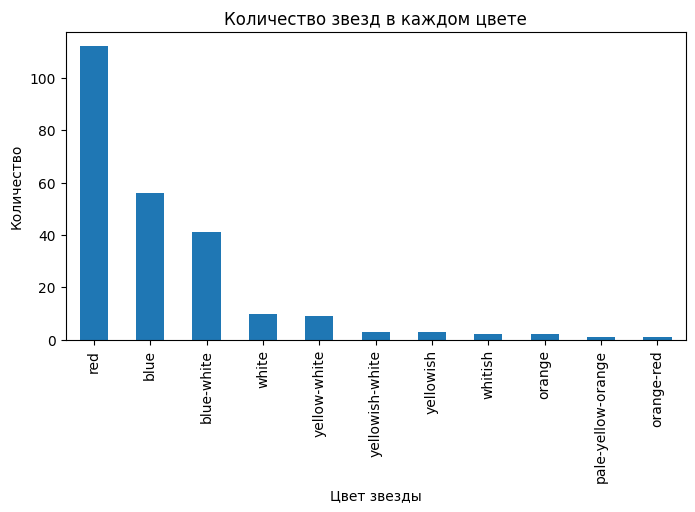

In [27]:
df['star_color'].value_counts().plot.bar(figsize=(8, 4))
plt.title('Количество звезд в каждом цвете')
plt.xlabel('Цвет звезды')
plt.ylabel('Количество');

Большинство представленных звезд имеет красный цвет, также преобладают голубые и бело-желтые.

In [28]:
df['star_color'].value_counts()

star_color
red                   112
blue                   56
blue-white             41
white                  10
yellow-white            9
yellowish-white         3
yellowish               3
whitish                 2
orange                  2
pale-yellow-orange      1
orange-red              1
Name: count, dtype: int64

Некоторых цветов слишком мало, объединим их в отделтную категорию other.

In [29]:
threshold = 9
df['star_color'] = df['star_color'].apply(lambda x: x if df['star_color'].value_counts()[x] >= threshold else 'other')

In [30]:
df['star_color'].value_counts()

star_color
red             112
blue             56
blue-white       41
other            12
white            10
yellow-white      9
Name: count, dtype: int64

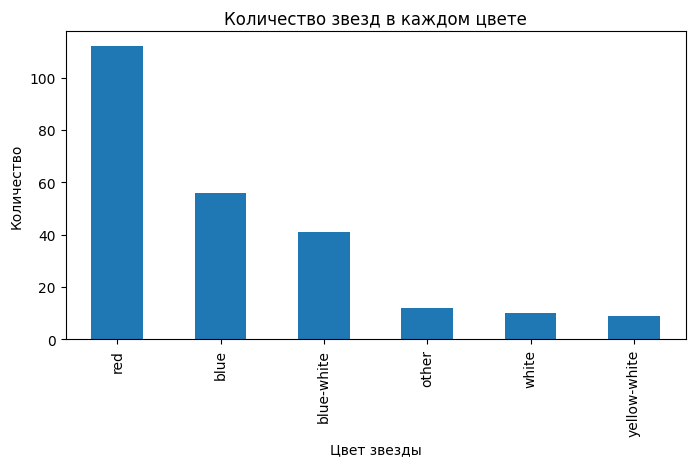

In [31]:
df['star_color'].value_counts().plot.bar(figsize=(8, 4))
plt.title('Количество звезд в каждом цвете')
plt.xlabel('Цвет звезды')
plt.ylabel('Количество');

**Выводы:** 
- Мы изменили названия столбцов
- Привели столбецы star_type и star_color в категориальный тип
- Удалили нерелевантный столбец
- Детально изучили каждый столбец
- Убрали неявные дубликаты в столбце star_color
- Объединила цвета которых меньше 9 в категорию other

## Подготовка данных к построению модели

Разделение данных на выборки

In [32]:
RANDOM_STATE = 12345

In [33]:
target = df['temperature']
features = df.drop('temperature', axis=1)

In [34]:
numeric = features.select_dtypes(include='float64').columns
categorical = features.select_dtypes(exclude='float64').columns
print(numeric)
categorical

Index(['luminosity', 'radius', 'absolute_magnitude'], dtype='object')


Index(['star_type', 'star_color'], dtype='object')

In [35]:
features_train, features_test, target_train,  target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)
print(f'Величина тренировочного датасета: {features_train.shape[0]}')
print(f'Величина тестового датасета: {features_test.shape[0]}')

Величина тренировочного датасета: 180
Величина тестового датасета: 60


Масштабирование числовых переменных

In [36]:
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Кодирование категориальных преременных

In [37]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(features_train[categorical])

features_train[encoder.get_feature_names_out()] = encoder.transform(features_train[categorical]) 
features_train = features_train.drop(categorical, axis=1)

features_test[encoder.get_feature_names_out()] = encoder.transform(features_test[categorical])
features_test = features_test.drop(categorical, axis=1)

In [38]:
features_train.head()

,luminosity,radius,absolute_magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue-white,star_color_other,star_color_red,star_color_white,star_color_yellow-white
99,0.573322,-0.412010,-0.894946,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,-0.586360,-0.433149,0.524323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-0.586360,-0.432117,0.537614,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
156,-0.501317,-0.421783,-0.837985,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
135,-0.586360,-0.431660,0.923047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Перевод датасета в тензор

In [39]:
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_test.values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

## Построение базовой нейронной сети

In [41]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)    
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 17
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

loss = nn.MSELoss()

num_epochs = 2500 

train_rmse_history = []
test_rmse_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = loss(preds,y_train)
    loss_value.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs:
        print("Эпоха: ", epoch)

        train_preds = net.forward(X_train)
        r2_train = np.round(r2_score(y_train, train_preds.detach().numpy()), 2)
        rmse_train = np.round(mean_squared_error(y_train, train_preds.detach().numpy(), squared=False))
        train_rmse_history.append(rmse_train)
        print(f"r2_train: {r2_train}, rmse_train: {rmse_train}")

        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2_test = np.round(r2_score(y_test, test_preds), 2)
        rmse_test = np.round(mean_squared_error(y_test, test_preds, squared=False))
        test_rmse_history.append(rmse_test)
        print(f"r2_test:  {r2_test}, rmse_test: {rmse_test}")


batch_size = None
learning_rate = None
drop_out = None
data = {
    "epoch": epoch, 
    "batch_size": batch_size, 
    "learning_rate": learning_rate, 
    "drop_out": drop_out, 
    "rmse_train": rmse_train, 
    "rmse_test": rmse_test, 
    "r2_train": r2_train, 
    "r2_test": r2_test}
results = pd.DataFrame([data])

Эпоха:  0
r2_train: -1.25, rmse_train: 13727.0
r2_test:  -1.15, rmse_test: 15460.0
Эпоха:  100
r2_train: -0.89, rmse_train: 12576.0
r2_test:  -0.81, rmse_test: 14217.0
Эпоха:  200
r2_train: 0.27, rmse_train: 7817.0
r2_test:  0.26, rmse_test: 9056.0
Эпоха:  300
r2_train: 0.42, rmse_train: 6952.0
r2_test:  0.43, rmse_test: 7961.0
Эпоха:  400
r2_train: 0.48, rmse_train: 6571.0
r2_test:  0.49, rmse_test: 7545.0
Эпоха:  500
r2_train: 0.56, rmse_train: 6092.0
r2_test:  0.58, rmse_test: 6872.0
Эпоха:  600
r2_train: 0.66, rmse_train: 5342.0
r2_test:  0.67, rmse_test: 6033.0
Эпоха:  700
r2_train: 0.74, rmse_train: 4656.0
r2_test:  0.74, rmse_test: 5371.0
Эпоха:  800
r2_train: 0.78, rmse_train: 4266.0
r2_test:  0.77, rmse_test: 5088.0
Эпоха:  900
r2_train: 0.81, rmse_train: 4022.0
r2_test:  0.78, rmse_test: 4974.0
Эпоха:  1000
r2_train: 0.83, rmse_train: 3807.0
r2_test:  0.8, rmse_test: 4678.0
Эпоха:  1100
r2_train: 0.84, rmse_train: 3631.0
r2_test:  0.82, rmse_test: 4501.0
Эпоха:  1200
r2_train

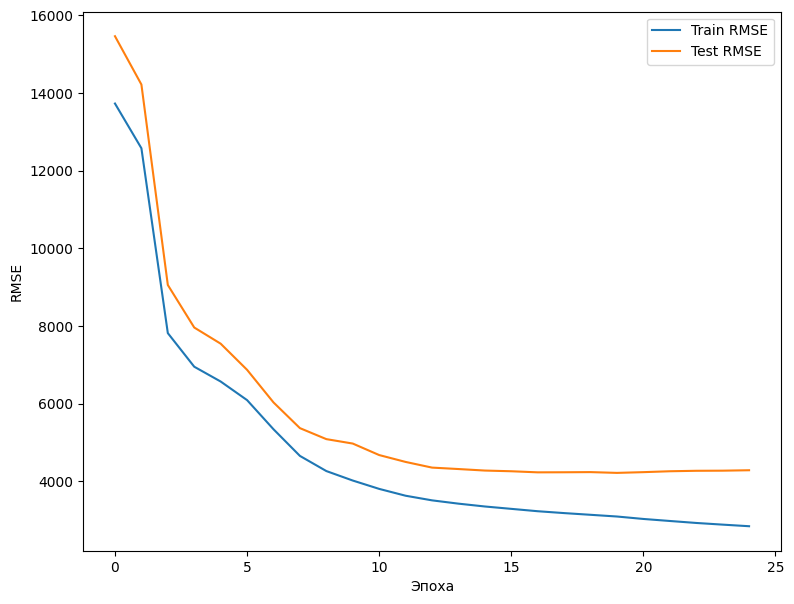

In [42]:
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(test_rmse_history, label='Test RMSE')
plt.xlabel('Эпоха')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [43]:
def vizual(y_pred, y_true):
    
    x = np.arange(len(y_true))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y_true, width = 0.9, label = 'Факт')
    forecast = ax.bar(x, y_pred , width = 0.4, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.grid(axis='y')
    plt.show()

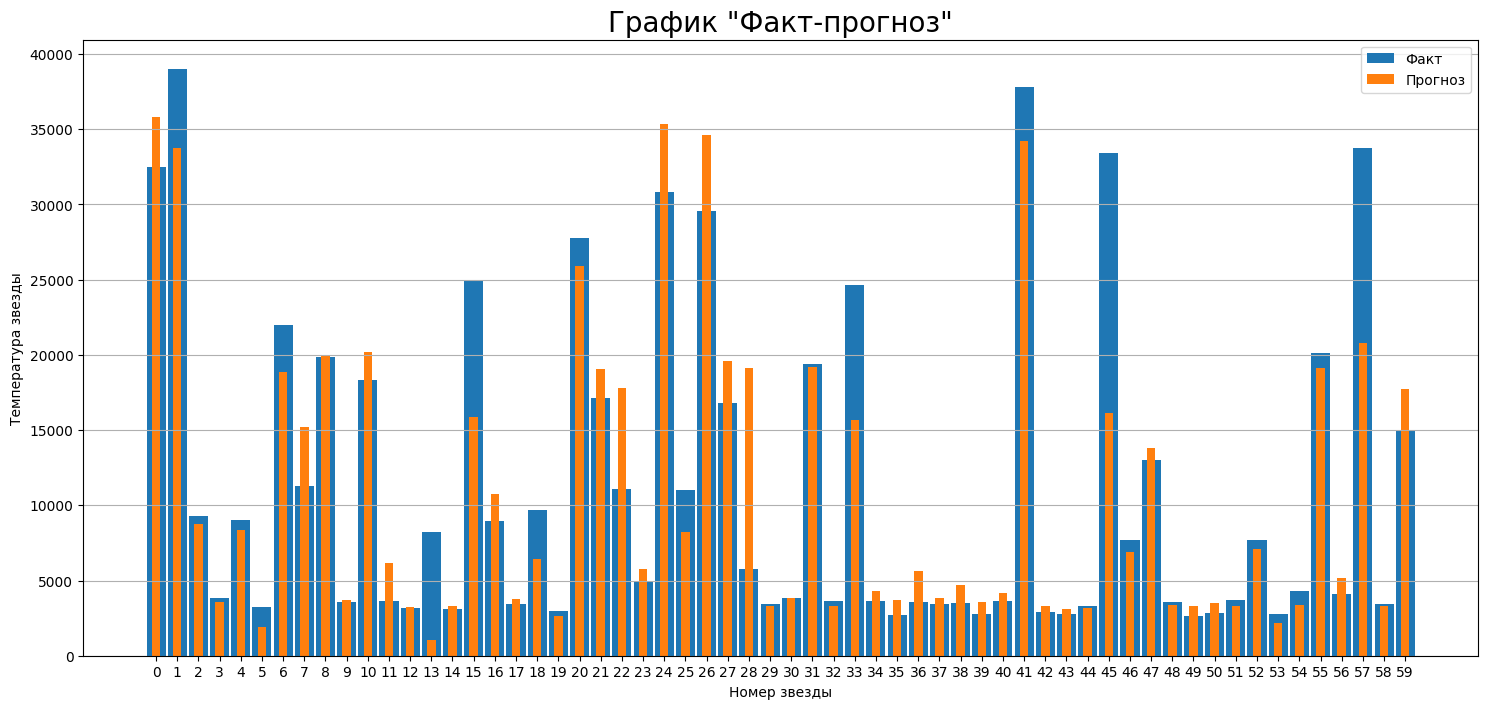

In [44]:
vizual(test_preds, y_test)

**Вывод:**\
Лучшее RMSE составило 4219 на эпохе 1900., что говорит о том, что модель демонстрирует хорошую производительность.\
Анализируя график сопоставления предсказанных и фактических значений температур звёзд, можно утверждать, что звезды с низкими температурами (до 5000К) прогнозируются хорошо. Звезды со средней и высокой температурой прогнозируются гораздо хуже, здесь удалось верно спрогнозировать мало звезд.

## Улучшение нейронной сети

Попробуем улучшить сеть путем перебора параметров, таких как dropout, размер батча и скорость обучения.

In [45]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(drop_out)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)     
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        return x

def objective(trial):
    
    num_epochs = 2500
    
    n_in_neurons = features_train.shape[1]
    n_hidden_neurons_1 = 25
    n_hidden_neurons_2 = 17
    n_out_neurons = 1
    
    learning_rate =  trial.suggest_float('learning_rate', 0.001, 0.1) #, step=0.005)
    drop_out = trial.suggest_float('drop_out', 0.1, 0.3) #, step=0.1)  
    batch_size = trial.suggest_int('batch_size', 30, 80) #, step=5)
    
    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
    loss = nn.MSELoss()
    
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            optimizer.zero_grad()
            preds = net.forward(X_batch).flatten() 
            loss_value = loss(preds,y_batch) 
            loss_value.backward()
            optimizer.step()
    
    with torch.no_grad():
        
        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2 = r2_score(y_test, test_preds)
        rmse = mean_squared_error(y_test, test_preds, squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=RANDOM_STATE), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

print("Лучшие параметры:", study.best_params)
print("Лучшее оптимальное значение целевой функции:", study.best_value)

[I 2024-09-21 16:50:34,155] A new study created in memory with name: no-name-53defff2-335b-4006-873e-87a78a25f77e
[I 2024-09-21 16:50:44,799] Trial 0 finished with value: 4437.88037109375 and parameters: {'learning_rate': 0.09303199318889764, 'drop_out': 0.16327511091635719, 'batch_size': 39}. Best is trial 0 with value: 4437.88037109375.
[I 2024-09-21 16:50:52,447] Trial 1 finished with value: 4946.6494140625 and parameters: {'learning_rate': 0.021251467576750935, 'drop_out': 0.21354500581633734, 'batch_size': 60}. Best is trial 0 with value: 4437.88037109375.
[I 2024-09-21 16:51:00,344] Trial 2 finished with value: 4920.619140625 and parameters: {'learning_rate': 0.09648693745382654, 'drop_out': 0.23063541937431417, 'batch_size': 68}. Best is trial 0 with value: 4437.88037109375.
[I 2024-09-21 16:51:08,213] Trial 3 finished with value: 4828.02587890625 and parameters: {'learning_rate': 0.0657034172143218, 'drop_out': 0.24954296185425476, 'batch_size': 79}. Best is trial 0 with value:

Лучшие параметры: {'learning_rate': 0.023143347809441096, 'drop_out': 0.15243487955302285, 'batch_size': 53}
Лучшее оптимальное значение целевой функции: 4059.168212890625


После перебора параметро показатель RMSE улучшился, обучим новую нейросеть с подобранными значениями гиперпараметров и посмотрим на график.

In [46]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

learning_rate = study.best_params["learning_rate"]
drop_out = study.best_params["drop_out"]
batch_size = study.best_params["batch_size"]


class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ELU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(drop_out)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)     
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        return x
   
n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 17
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, drop_out)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 
loss = nn.MSELoss()
     
num_epochs = 2500
batch_size = batch_size

num_batches = ceil(len(X_train)/batch_size)

best_loss = None
counter = 0
patience = 4

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size 
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        optimizer.zero_grad()
        preds = net.forward(X_batch).flatten() 
        loss_value = loss(preds,y_batch) 
        loss_value.backward()
        optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs:
        print("Эпоха: ", epoch)
    
        train_preds = net.forward(X_train)
        r2_train = np.round(r2_score(y_train, train_preds.detach().numpy()), 2)
        rmse_train = np.round(mean_squared_error(y_train, train_preds.detach().numpy(), squared=False))
        print(f"r2_train: {r2_train}, rmse_train: {rmse_train}")

        net.eval()
        test_preds = net.forward(X_test)
        test_preds = test_preds.flatten().detach().numpy()
        r2_test = np.round(r2_score(y_test, test_preds), 2)
        rmse_test = np.round(mean_squared_error(y_test, test_preds, squared=False))
        print(f"r2_test:  {r2_test}, rmse_test: {rmse_test}")

        # Добавим критерий остановы        
        if best_loss == None:
            best_loss = loss_value
        elif best_loss - loss_value > 0:
            best_loss = loss_value
            counter = 0
        elif best_loss - loss_value < 0:
            counter += 1
        if counter >= patience:
            print('Ранняя остановка:', epoch)
            break

data = {
    "epoch": epoch, 
    "batch_size": batch_size, 
    "learning_rate": learning_rate, 
    "drop_out": drop_out, 
    "rmse_train": rmse_train, 
    "rmse_test": rmse_test, 
    "r2_train": r2_train, 
    "r2_test": r2_test}
results = pd.concat([results, pd.DataFrame([data])])

Эпоха:  0
r2_train: -1.25, rmse_train: 13726.0
r2_test:  -1.15, rmse_test: 15460.0
Эпоха:  50
r2_train: 0.47, rmse_train: 6659.0
r2_test:  0.49, rmse_test: 7547.0
Эпоха:  100
r2_train: 0.74, rmse_train: 4671.0
r2_test:  0.75, rmse_test: 5315.0
Эпоха:  150
r2_train: 0.82, rmse_train: 3922.0
r2_test:  0.79, rmse_test: 4781.0
Эпоха:  200
r2_train: 0.84, rmse_train: 3691.0
r2_test:  0.81, rmse_test: 4644.0
Эпоха:  250
r2_train: 0.85, rmse_train: 3531.0
r2_test:  0.81, rmse_test: 4542.0
Эпоха:  300
r2_train: 0.86, rmse_train: 3413.0
r2_test:  0.81, rmse_test: 4582.0
Ранняя остановка: 300


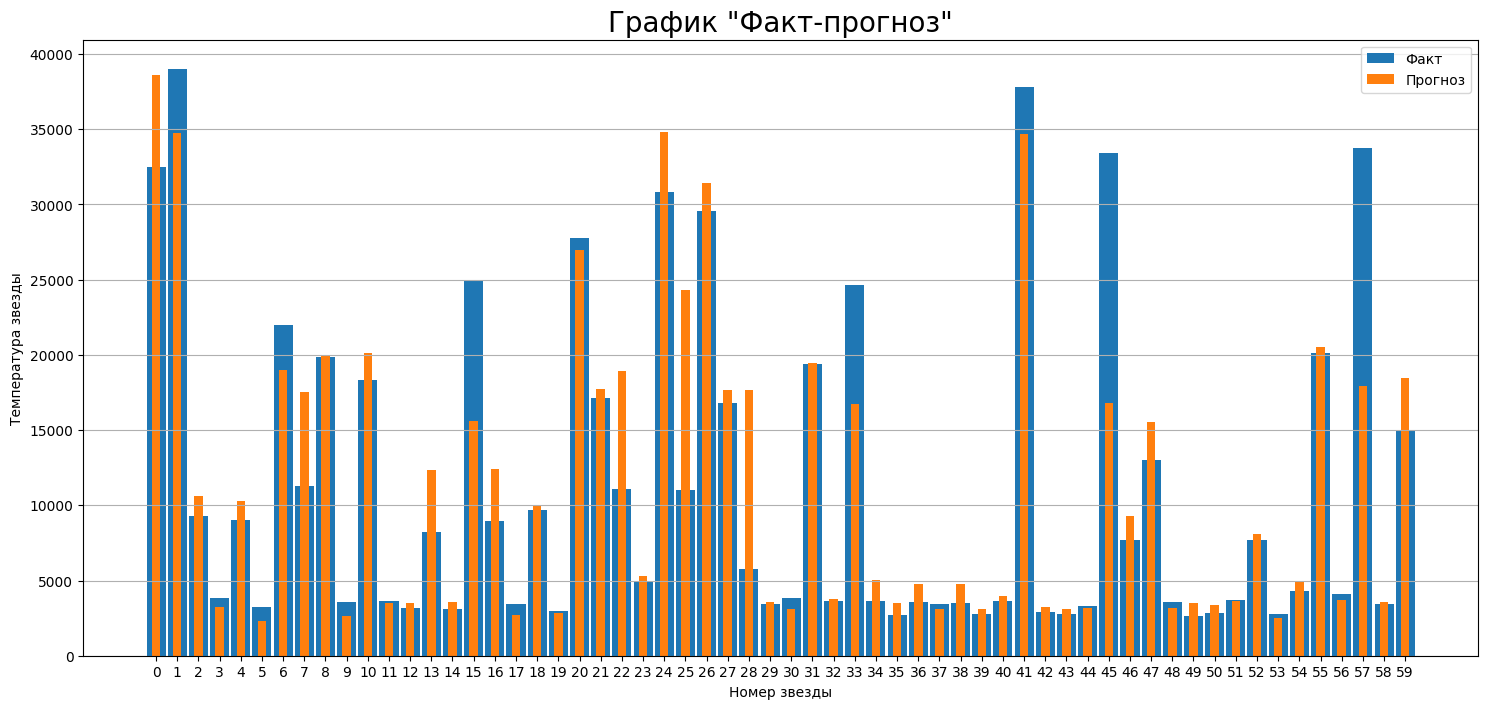

In [47]:
vizual(test_preds, y_test)

Нейронная сеть с гиперпараметрами подобранными тюнингом стала  хуже прогнозировать температуру на поверхности звезд как при малых температурах так и при средних, прогносирование при высоких температурах почти не изменилось.

In [48]:
results

,epoch,batch_size,learning_rate,drop_out,rmse_train,rmse_test,r2_train,r2_test
0,2499,None,NaN,NaN,2846.0,4287.0,0.90,0.83
0,300,53,0.023143,0.152435,3413.0,4582.0,0.86,0.81


## Вывод

Загрузили данные.
Была сделана предобработка данных.
- Изменили названия столбцов.
- Привели признаки star_type и star_color к категориальному типу.
- Удалили неинформативныйй столбец unnamed_0.
- Избавились от дублирующихся названий звезд.

Разделили данные на выборки.\
Произвели кодирование и масштабирование данных.\
Перевели датасет в тензор.\
\
Построили базовую нейронную сеть, которая имеет:
- 2 скрытых слоя
- функцию активации nn.ELU() на первом слое и nn.ReLU() на втором
- 18 нейронов на входном слое, 25 нейронов в первом слое, 17 нейронов во втором слое и 1 нейрон на выходе
- скорость обучения 1e-2
- количество эпох 2500 

На тестовых данных мы получили RMSE 4287 тем самым выполнив условие, что значение целевой метрики RMSE должно быть меньше 4500.\
Улучшение модели путем перебора параметров dropout, размер батча и скорость обучения при помощи optuna, не удалось, показание метрики rmse  ухудшилось - 4639.0.\
Таким образом лучшим вариантом сети с rmse на тестовой выборке = 4287 оказалась базовая сеть обученная без разбиения на батчи и использолвания «dropout»

